## Kernel Density Estimation

- Pros:
    - Can be used an Generative Classifier(generalization of Naive Bayes Classifier)
    - Results are easily interpretable (Not only get the label, but a assignement probability)
    
- Cons:
    - Might be computanionally expensive
    - Need GridSearch to find best kernel_bandwidth


- **Density Estimator:** Model the proba. distribution that generated a dataset
- Take GMM to its extreme: Uses a mixture of one Gaussian component PER SAMPLE

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_theme();
plt.rcParams['figure.figsize'] = (10, 6) # Change the default value of figsize, default is too small

<AxesSubplot:>

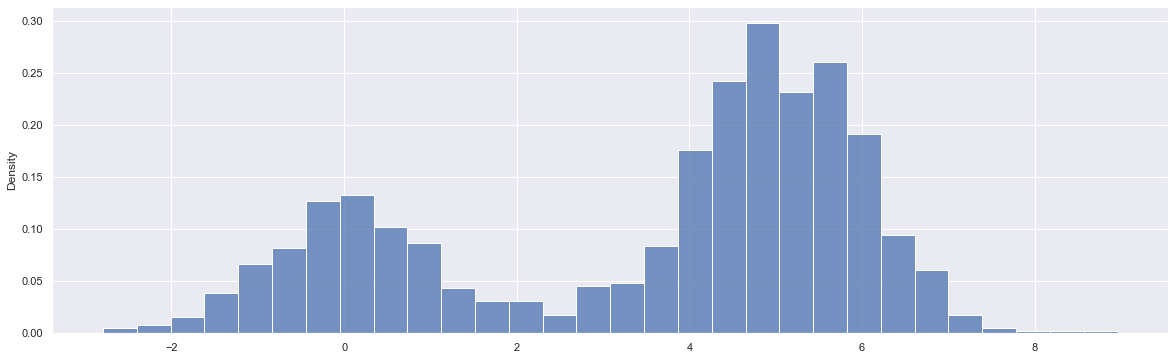

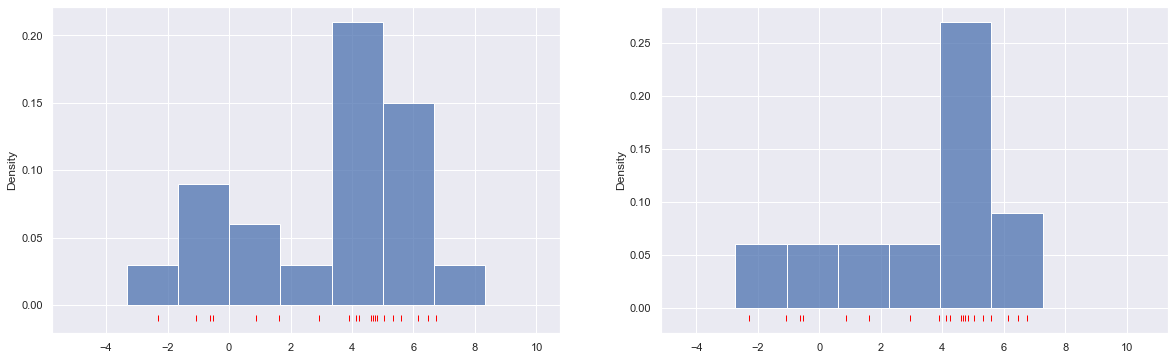

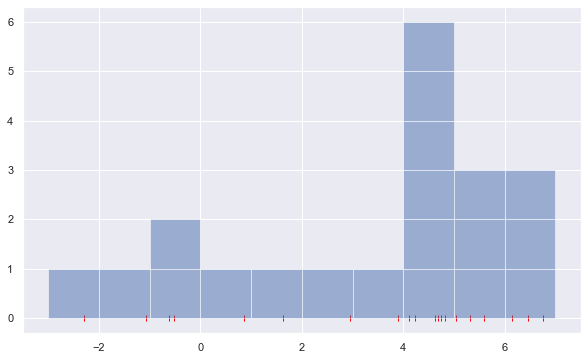

In [3]:
# Motivation

# 1D Density Estimator: Histogram (divide data into bins and counts the nb of points that fall in each bin)
def make_data(N, f=0.3, rseed=1):
    rng = np.random.RandomState(rseed)
    x = rng.randn(N)
    x[int(f*N):] += 5 # Scale up 70% of the samples to make 2 different distributions
    return x

# Plot 1000 points from distribution
x = make_data(1000)
fig, ax = plt.subplots(figsize = (20, 6))
hist = sns.histplot(data=x,
                    bins=30,
                    stat='density', # Normalize such that the total area of the histogram equals 1 -> As a proba. distrib.
                    ax=ax 
                    #kde = True
                    )

# Plot 20 points from distribution with diff. bin distribution
fig, axes = plt.subplots(1, 2, figsize = (20, 6))
x = make_data(20)
bins = np.linspace(-5, 10, 10)
for idx, offset in enumerate([0.0, 0.6]):
    hist = sns.histplot(data=x,
                         bins=bins + offset,# Shift the bins to the right
                         stat='density', # Normalize such that the total area of the histogram equals 1 -> As a proba. distrib.
                         ax=axes[idx]
                        )
    # Mark the original datapoints
    y = np.full_like(x, -0.01) # Generate y coordonate. All points as the same y coordondate: -0.01
    sns.scatterplot(x=x,
                    y=y,
                    marker = '|',
                    color="red",
                    linewidth=1,
                    ax=axes[idx]
                    )

# Problem: The choice of bin distribution can lead to different density estimator
# On the left plot, we clearly see a bimodal distribution
# On the right plot, we see an unimodal distribution with long tail
# But, the 2 plots were built from the same data.

# Think of histogram as stack of blocks
fig, ax = plt.subplots(figsize = (10, 6))
bins = np.arange(-3, 8)


# Get the bin distribution
counts, edges = np.histogram(x, bins) # Return the number of points in each bin, and the left x-cordonate of each bin
# For each bin, draw the blocks (stack of squares)
for count, edge in zip(counts, edges):
    # For each element in bin, draw a 1 square
    for i in range(count):
        ax.add_patch(plt.Rectangle((edge, i), # Bottom-left coordonate of the square
                                    1, # width
                                    1, # height
                                    alpha=0.5))
        
sns.scatterplot(x=x, y=y,marker = '|', color="red",
                linewidth=1,
                ax=ax)
        

# Solution: Instead of stackling the blocks aligned with BINS,
#           we were to stack the blocks aligned with the POINTS they represent

Shape of x_segment_counts: (2000,)
Number of blocks in x_segment_counts: 3331


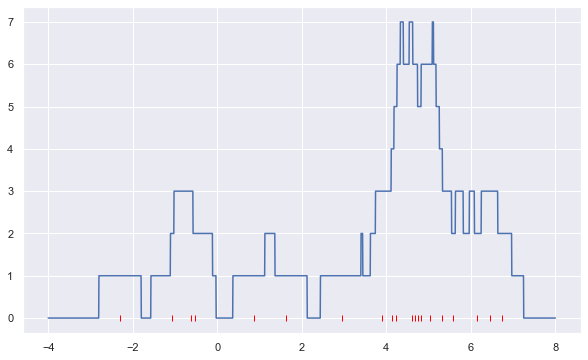

In [179]:
# Stack the blocks aligned with the points they represent

x_segment = np.linspace(-4, 8, 2000)
# For each sample, find all the points on the segment with distance < 0.5 (True if they are close enough)
x_closeness = [abs(x_i - x_segment) < 0.5 for x_i in x]
# # For each point on the segment, count how many sample is contains
# (a same sample is assigned to many point on the segment)
x_segment_counts = sum(x_closeness)
print(f"Shape of x_segment_counts: {x_segment_counts.shape}")
print(f"Number of blocks in x_segment_counts: {sum(x_segment_counts)}")

# -> We break the binary decision of histogram: a sample belongs to all its neighors "bins"
ax = sns.lineplot(x=x_segment,
             y=x_segment_counts)
sns.scatterplot(x=x, y=y,
                marker = '|',
                color="red",
                ax=ax,
                linewidth=1);

# -> This is a Kernel Density Estimation in 1D with "tophat" kernel

# Problem: The rough edges are not aesthetically pleasing. Let's smooth them out by replacing the 
#          blocks with a smooth function, like a Gaussian

Shape of x: 20
Len of x_closeness: 20
Shape of x_closeness[0]: (2000,)
x_segment_counts counts: 3288.5960281855414


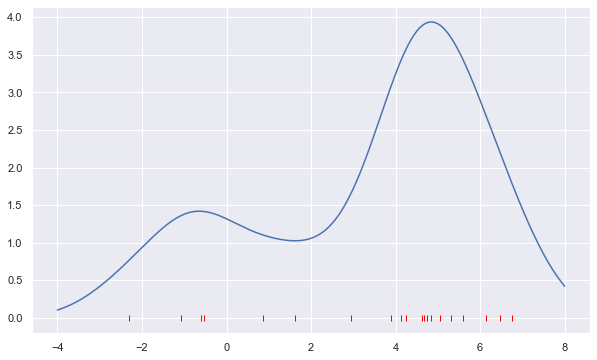

In [180]:
# Replace the blocks with a smooth function: a Gaussian

from scipy.stats import norm

x_segment = np.linspace(-4, 8, 2000)
# For each sample i, create a normal distribution *f_i* with mean = sample,
# and compute *f_i()* for all points on the segment
x_closeness = [norm(x_i).pdf(x_segment) for x_i in x]
print(f"Shape of x: {len(x)}")
print(f"Len of x_closeness: {len(x_closeness)}")
print(f"Shape of x_closeness[0]: {x_closeness[0].shape}")
# For each sample, we have a closeness array of length 2'000 defining how much it contributes to the pts on the seg.

# For each point on the segment, sum the corresponding weight of each sample
x_segment_counts = sum(x_closeness)
print(f"x_segment_counts counts: {sum(x_segment_counts)}")

# -> We break the rough edge of blocks with a smooth curve
ax = sns.lineplot(x=x_segment,
             y=x_segment_counts)
sns.scatterplot(x=x, y=y,
                marker = '|',
                color="red",
                ax=ax,
                linewidth=1);

# We have obtained a smooth plot: with a Gaussian distribution contributed at the location of each input points

# -> This is a Kernel Density Estimation in 1D with Gaussian kernel

In [7]:
# The free parameters of the KDE are:
# - The kernel, which specifies the shape of the distribution placed at each point
# - The kernel bandwidth, which control the size of the kernel at each point (standard deviation ?) 
#   kernel bandwidth can be determined using standard cross validation tools

# KDE might be computanionally expensive -> sklearn uses a tree-based algo so that we can trade off computational
# time for accuracy

<AxesSubplot:>

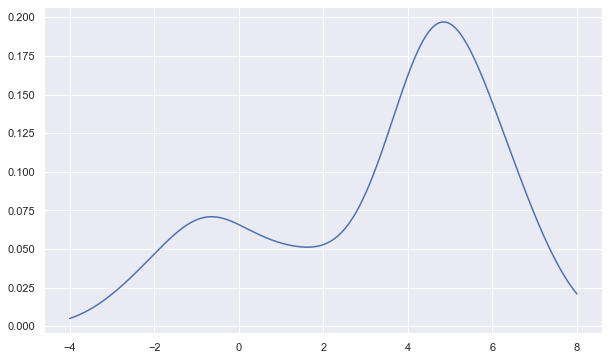

In [8]:
## sklearn KernelDensity estimator
from sklearn.neighbors import KernelDensity

# Create the KDE model
kde = KernelDensity(bandwidth=1.0,
                    kernel='gaussian' # Use a Gaussian kernel
                   )
kde.fit(x[:, np.newaxis])

# Get the probability scores for point on the segment
# The score_samples returns the log of the probabilities
y_kde = np.exp(kde.score_samples(x_segment[:, np.newaxis]))

sns.lineplot(x=x_segment,
             y=y_kde)

In [9]:
## Select the bandwidth

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut

# Define bandwidths to test
bandwidths = 10**np.linspace(-1, 1, 100)

# Call model.get_params to get the full list of params
grid = GridSearchCV(KernelDensity(kernel='gaussian'), # Define the model to test via GridSearch
                    {"bandwidth": bandwidths}, # Define the parameter to test
                    cv=LeaveOneOut() # Define the cross-validation splitting strategy:
                                     # Leave-one out cross validation (Train on all the datapoints except one
                                     # -> nb_sample models = 20 models. Validation set contains only 1 sample)
                   )
# Compute the best estimator
grid.fit(x[:, np.newaxis])

# Extract the best params
bandwidth_best = grid.best_params_
print(f"Best bandwidth estimator: {bandwidth_best}")

Best bandwidth estimator: {'bandwidth': 1.1233240329780276}


Length of lat_lon: (1624, 2)
Length of species: 1624


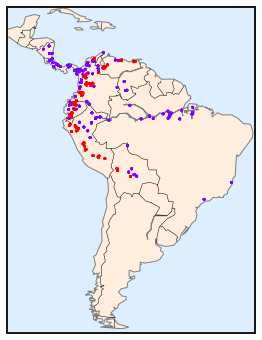

In [176]:
# Example: Visualization of distribution

# Data = Observation of two mammals in South America: Sloth and Rat
from sklearn.datasets import fetch_species_distributions
data = fetch_species_distributions()

# Get arrays of locations (latitude and longiture) and species IDs
lat_lon = np.vstack([data.train["dd lat"],
                     data.train["dd long"]]).T

# decode() take a byte reprensentation of a str and decode it
# 1 if species start with "micro" -> species is a rat, 0 o.w. -> species is a sloth
is_rat = np.array([d.decode("ascii").startswith("micro") for d in data.train["species"]], dtype="int")

print(f"Length of lat_lon: {lat_lon.shape}")
print(f"Length of species: {len(is_rat)}")

# Plot the oberserved location on a map
from mpl_toolkits.basemap import Basemap
from sklearn.datasets.species_distributions import construct_grids

# The grid is equaly spaced between the min and max latitude (x_grid) and longitude (y_grid) with a margin
x_grid, y_grid = construct_grids(data)
# Set up a basemap with specified map projection & costlines
m = Basemap(projection="cyl", # Choose a Cylindrical Equidistant projectin
            llcrnrlat=y_grid.min(), # Latitude in lower-left corner
            urcrnrlat=y_grid.max(), # Latitude in upper-right corner
            llcrnrlon=x_grid.min(), # Longitude in lower-left corner
            urcrnrlon=x_grid.max() # Longitude in upper-right corner
           )

m.drawmapboundary(fill_color = "#DDEEFF",
                  linewidth=2) # Draw the edges around the map
m.fillcontinents(color="#FFEEDD") # Draw the continents
m.drawcoastlines(color="gray") # Draw limits between continent and ocean
m.drawcountries(color="black") # Draw frontieres between countries

m.scatter(lat_lon[:, 1], # x is longitude in degree
          lat_lon[:, 0],
          zorder = 3, # Specify the order in which the various compoenents are layered on top of each other
                      # Markers will be on top. By default, ranges from 0 to 5 according to the Artist subtype
          c = is_rat,
          s = 3,
          cmap="rainbow",
          latlon=True # x and y are transformed to map project coordonate
         )

# Problem: Markers may overlap, preventing us from having a good idea of the density of the species.
#          Indeed, there are 1'624 points drawn

# -> Use KDE to show the distribution

In [160]:
lat_lon.shape

(1624, 2)

In [158]:
x_grid.shape, y_grid.shape

((1212,), (1592,))

In [166]:
y_grid[::5][::-1][0], y_grid[::5][::-1][1]

(23.49999999999548, 23.249999999995495)

In [175]:
data.coverages[6].shape

(1592, 1212)

Shape of x_grid: (1212,)
Shape of y_grid: (1592,)

Shape of X: (319, 243)
Shape of Y: (319, 243)

Shape of land_mask: (77517,)
Shape of XY: (77517, 2)
Shape of XY(land conly): (28008, 2)

Shape of Z function: (319, 243)
Shape of Z function: (319, 243)


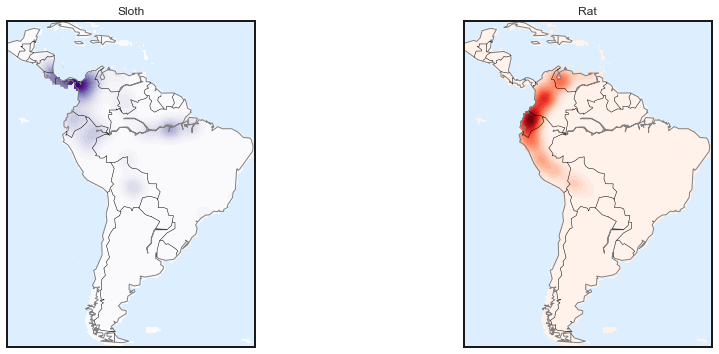

In [178]:
# Visualize the distribution on the map
# Set up the grid
print(f"Shape of x_grid: {x_grid.shape}") # x_grid contains the longitude
print(f"Shape of y_grid: {y_grid.shape}\n") # y_grid contains the latitude
X, Y = np.meshgrid(x_grid[::5], y_grid[::5][::-1]) # Skip 4/5 of the original grid points. Reverse the latitude
print(f"Shape of X: {X.shape}")
print(f"Shape of Y: {Y.shape}\n")
# coverage[6] has measurements at all land points
land_reference = data.coverages[6][::5, ::5] # Skip 4/5 of the coverages
land_mask = (land_reference > -9999).ravel() # True if point belongs to continent, False if point belongs to water
print(f"Shape of land_mask: {land_mask.shape}") # 319*243 = 77'517
# Make X and Y 1-Dimension to facilitate computation later
XY = np.vstack([Y.ravel(), X.ravel()]).T
print(f"Shape of XY: {XY.shape}")
# Keep only point on continent and Convert latitude and longitude to randians
XY = np.radians(XY[land_mask])
print(f"Shape of XY(land conly): {XY.shape}\n")

# Set up the plot
fig, axes = plt.subplots(1, 2, figsize=(15,6))
species_names = ["Sloth", "Rat"]
cmaps = ["Purples", "Reds"]

for i, ax in enumerate(axes):
    ax.set_title(species_names[i])
    # Plot basic map objects(continents, coastlines, countries)
    m = Basemap(projection="cyl", # Choose a Cylindrical Equidistant projectin
            llcrnrlat=Y.min(), # Latitude in lower-left corner
            urcrnrlat=Y.max(), # Latitude in upper-right corner
            llcrnrlon=X.min(), # Longitude in lower-left corner
            urcrnrlon=X.max(), # Longitude in upper-right corner
            ax=ax
           )
    m.drawmapboundary(fill_color = "#DDEEFF",
                      linewidth=2) # Draw the edges around the map
    # m.fillcontinents(color="#FFEEDD") # Draw the continents
    m.drawcoastlines(color="gray") # Draw limits between continent and ocean
    m.drawcountries(color="black") # Draw frontieres between countries
    
    # Train a spherical KDE (Gaussian kernel by default)
    kde = KernelDensity(bandwidth=0.03,
                        metric="haversine", # Because coordonates lies on a spherical surface rather than a flat plane,
                                            # Use the "haversine" distance metric for curved surface
                                            # Assume training set are long. and lat. in radians
                        )
    kde.fit(np.radians(lat_lon[is_rat == i])) # Train on the location of the current specie on the original data
    
    # For each point on the grid, compute its probabily
    Z = np.full(land_mask.shape[0], -9999.0) # -9999 indicates ocean, so probability will be 0
    Z[land_mask] = np.exp(kde.score_samples(XY)) # The log of the proba is returned by score_samples
    Z = Z.reshape(X.shape)
    print(f"Shape of Z function: {Z.shape}")
    
    # Plot contour line filled
    levels = np.linspace(0, Z.max(), 25) # Define 25 lines
    ax.contourf(X, Y, Z, levels=levels, cmap=cmaps[i])
    

In [307]:
## KDE for classification

# In Gaussian Naive classifier, each label is modeled according to a Bayes generative model
# in which the shape of the cluster are axis-aligned. With KDE we can relax this assumption and take 
# a more sophisticated generative model for each class

# 1 - Split the training set by label
# 2 - For each set, fit a KDE. So, for any sample x and label y, we can compute Pr(x|y)
#     Now we need Pr(y) to compute the final Pr(y|x) . Pr(y) is the weight of each
# 3 - For a unknow point x, assign x to the y wich maximize Pr(x|y)*Pr(y)

# Create our own Estimator
from sklearn.base import BaseEstimator, ClassifierMixin


# BaseEstimator and ClassifierMixin provides standard functionality
# - BaseEstimator contains the logic necessary to clone an estimator for use in cross-validation 
# - ClassifierMixin defines a default score() method used by cross-validation
class KDEClassifier(BaseEstimator, ClassifierMixin):
    """
    Bayesian Generative Classification based on KDE
    
    Args:
        bandwith: np.array
            the kernel bandwith within each class
        kernel: str
            the kernel name, passed to KernelDensity
    """
    
    def __init__(self, bandwidth=1.0, kernel='gaussian'):
        # Should not contains any operation other than assigning passed values by names to self.
        # And all paramter in init should be explicit. No *args or **kwargs
        self.bandwidth = bandwidth
        self.kernel = kernel
        
    def fit(self, X, y):
        ##print(f"Shape of X: {X.shape}")
        ##print(f"Shape of y: {y.shape}\n")
        # Keep track of the classes
        self.classes_ = np.sort(np.unique(y))
        ##print(f"self.classes: {self.classes_}")
        # Compute the Pr(y)
        self.weights_ = np.array([np.sum(y == c) for c in self.classes_])/len(y)
        ##print(f"Number of classes: {len(self.classes_)}\n")
        ##print(f"Weight of classes: {self.weights_}")
        ##print(f"Shape of weigths_: {self.weights_.shape}\n")
        # Construct one KDE Generator
        self.models_ = np.array([KernelDensity(bandwidth=self.bandwidth[idx],
                                               kernel=self.kernel).fit(X[y == c])
                                 for idx, c in enumerate(self.classes_)])
        ##print(f"Shape of models: {self.models_.shape}\n")
        
        # The fit() method should always return self to chain command
        return self
        
    def predict(self, X):
        # Evaluate the probability that each sample belongs to each class
        # Do not forget that the log proba is returned, so take the exponential to cancel out
        ##print(f"Shape of X: {X.shape}")
        ##print(f"Score samples shape: {self.models_[0].score_samples(X).shape}")
        p_X_knowing_Y = np.exp(np.array([model.score_samples(X) for model in self.models_]))
        ##print(f"Shape of p_X_knowing_Y: {p_X_knowing_Y.shape}")
        ##print(f"Shape of self.weights_[:, np.newaxis]: {self.weights_[:, np.newaxis].shape}")
        # For each sample, select the class with maximal likelihood
        self.proba_ = p_X_knowing_Y*self.weights_[:, np.newaxis]
        ##print(f"Shape of self.proba: {self.proba_.shape}")
        
        # Map to corresponding class
        y_index = np.argmax(self.proba_, axis = 0)
        ##print(f"Shape of y_index: {y_index.shape}")
        y = self.classes_[y_index]
        ##print(f"Shape of y: {y.shape}")
        
        return y
        
    

In [ ]:
# Try our custom estimator: Hand-written digits

from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV

digits = load_digits()
print(f"Shape of data: {digits.data.shape}")
print(f"Shape of target: {digits.target.shape}\n")

# Define the parameter to test
bands = 10**np.linspace(0, 1, 100)
n_search = 1000
bandwidths = [np.random.choice(bands,
                               size=10) for i in range(n_search)]
grid = GridSearchCV(KDEClassifier(), # Model to test with GridSearch
                    {"bandwidth": bandwidths} # Parameter values to play with
                    )
%timeit grid.fit(digits.data, digits.target)

Shape of data: (1797, 64)
Shape of target: (1797,)



/Users/nicolas/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/nicolas/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/nicolas/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/nicolas/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The d

Best param: {'bandwidth': array([ 1.        ,  1.29154967,  2.15443469,  7.74263683,  3.59381366,
        5.9948425 ,  1.66810054,  2.7825594 , 10.        ,  4.64158883])} with accuracy: 0.4785754034501948


/Users/nicolas/anaconda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


TypeError: unhashable type: 'numpy.ndarray'

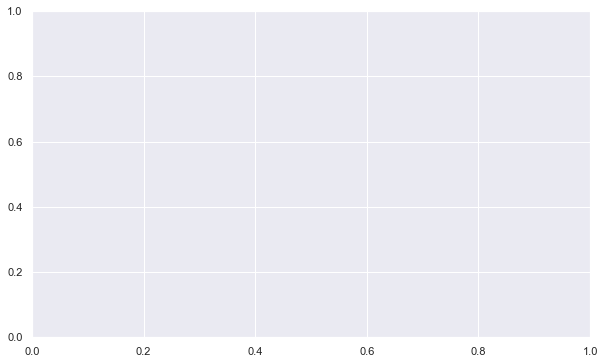

In [310]:
# Plot the score of each GridSearch estimator
scores = grid.cv_results_["mean_test_score"]

print(f"Best param: {grid.best_params_} with accuracy: {grid.best_score_}")

fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.lineplot(bandwidths, scores)
ax.set(xlabel="Bandwidth",
       ylabel="Score",
       xscale = "log")
ax.set_title("KDE Model Performance");

In [289]:
# Our own Gaussian KDE classifier outperforms the Naive Gaussian Estimator

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score # Evaluate estimator using 3-fold cross-validation
cross_val_score(GaussianNB(), digits.data, digits.target).mean()



/Users/nicolas/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.8186003803550138

In [286]:
cross_val_score?

In [275]:
grid.cv_results_["mean_test_score"].max()

0.9666110183639399

In [194]:
a = np.array([[2,2,10,2,2,2],
              [5,5,5,5,5,5]])
b = np.array([[2],
              [10]])
a.shape, b.shape

((2, 6), (2, 1))

In [195]:
a.argmax(0)

array([1, 1, 0, 1, 1, 1])

In [213]:
y = digits.target
y

array([0, 1, 2, ..., 8, 9, 8])

In [222]:
np.sum(np.array([np.sum(y == c) for c in np.sort(np.unique(y))])/len(y))

1.0

In [217]:
len(y)

1797

In [218]:
np.sum(y[y == ])

/Users/nicolas/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """Entry point for launching an IPython kernel.


0

In [220]:
(y == 9).sum()

180

#### Concept Summary:


- Histogram: Bad data distribution visualization because of bin binary decision:
    - Replace bin with closenest function.
    - Replace blocks with a smooth function.
    
    
- KDE: 
    1. For each sample, create a probability distribution(e.g. Gaussian) centered at the sample coordonate and compute how likely it is that all the points on the grid(!= samples) were drawn from the distribution
    2. Finally, at each location on the grid, that the sum of all the gaussian probabilites computes in the previous step
    
    - Free parameters:
        - Choice of the *kernel*
        - Choice of the *kernel bandwith*: Control the bias-variance(overfitting). Too wide leads to high-bias estimate. Use cross-validation to get the "best" choice (Grid Search)
    
    
- KDE: Kernel means basis function computes for EACH sample.

- KDE for classification (Go further than Naive Gaussian Classification)



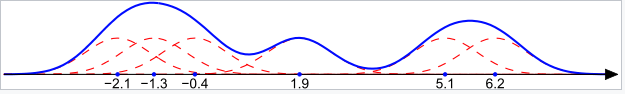